In [64]:
#Importing packages
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import datetime
import seaborn as sns

%config InlineBackend.figure_format = 'svg'

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

import folium # map rendering library

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print("Libraries imported!")

Libraries imported!


In [2]:
df = pd.read_csv("all_combined.csv", index_col="Unnamed: 0")
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/20/2021,00:00:00,REGULAR,7547270,2575125
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/20/2021,04:00:00,REGULAR,7547275,2575125
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/20/2021,08:00:00,REGULAR,7547290,2575135
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/20/2021,12:00:00,REGULAR,7547327,2575183
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/20/2021,16:00:00,REGULAR,7547418,2575215


In [3]:
df.shape

(3563231, 11)

- This dataset has 3563231 rows and 11 columns. <br />
- Now let's check out the data types of each rows and the columns of the dataset

In [4]:
df.dtypes

C/A                                                                     object
UNIT                                                                    object
SCP                                                                     object
STATION                                                                 object
LINENAME                                                                object
DIVISION                                                                object
DATE                                                                    object
TIME                                                                    object
DESC                                                                    object
ENTRIES                                                                  int64
EXITS                                                                    int64
dtype: object

In [5]:
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [6]:
df.columns = [column.strip() for column in df.columns]
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

- Looks like all columns have the dame data types of object, which is **NOT** good for `DATE` and `TIME` field, also the `ENTRIES` and `EXITS` should be `integer` instead of `object`. 
- So, let's create a new column named `DATE_TIME` of the **datetime** datatype combining two columns `DATE` and `TIME` using [pd.to_datetime](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) and convert `ENTRIES` and `EXITS` to datatype `int` using [pd.DataFrame.astype](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html).

In [7]:
#Create another column called DATE_TIME
df['DATE_TIME'] = pd.to_datetime(df.DATE + " " + df.TIME,
                                      format="%m/%d/%Y %H:%M:%S")
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/20/2021,00:00:00,REGULAR,7547270,2575125,2021-03-20 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/20/2021,04:00:00,REGULAR,7547275,2575125,2021-03-20 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/20/2021,08:00:00,REGULAR,7547290,2575135,2021-03-20 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/20/2021,12:00:00,REGULAR,7547327,2575183,2021-03-20 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/20/2021,16:00:00,REGULAR,7547418,2575215,2021-03-20 16:00:00


- Now we look at some basic information of the dataframe.

In [8]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3563231 entries, 0 to 209779
Data columns (total 12 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   C/A        3563231 non-null  object        
 1   UNIT       3563231 non-null  object        
 2   SCP        3563231 non-null  object        
 3   STATION    3563231 non-null  object        
 4   LINENAME   3563231 non-null  object        
 5   DIVISION   3563231 non-null  object        
 6   DATE       3563231 non-null  object        
 7   TIME       3563231 non-null  object        
 8   DESC       3563231 non-null  object        
 9   ENTRIES    3563231 non-null  int64         
 10  EXITS      3563231 non-null  int64         
 11  DATE_TIME  3563231 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 353.4+ MB


In [9]:
df.describe()

,ENTRIES,EXITS
count,3.563231e+06,3.563231e+06
mean,4.218128e+07,3.401142e+07
std,2.184420e+08,1.948236e+08
min,0.000000e+00,0.000000e+00
25%,2.288135e+05,9.472100e+04
50%,1.551587e+06,9.179380e+05
75%,6.197502e+06,4.074261e+06
max,2.128726e+09,2.123103e+09


### Closer look at the dataset:
> According to the mta's website, each combination of `C/A`, `UNIT`, `SCP`, and `STATION` represents a unique turnstile. Let's mask the dataframe based on uniquely identified turnstile and see what it shows at one specific day.

In [10]:
mask = ((df['C/A'] == 'TRAM2') 
& (df['UNIT'] == 'R469') 
& (df['SCP'] == '00-03-01') 
& (df['STATION'] == 'RIT-ROOSEVELT')
& (df['DATE'] == '03/13/2021'))
df[mask]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
206928,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,03/13/2021,00:00:00,REGULAR,3133536,397450,2021-03-13 00:00:00
206929,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,03/13/2021,04:00:00,REGULAR,3133536,397450,2021-03-13 04:00:00
206930,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,03/13/2021,08:00:00,REGULAR,3133536,397450,2021-03-13 08:00:00
206931,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,03/13/2021,12:00:00,REGULAR,3133536,397450,2021-03-13 12:00:00
206932,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,03/13/2021,16:00:00,REGULAR,3133536,397450,2021-03-13 16:00:00
206933,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,03/13/2021,20:00:00,REGULAR,3133536,397450,2021-03-13 20:00:00


- Looks like for each day, the system logs in the records for each turnstile every 4 hours (which is why we have 6 rows for one day per turnstile).
- Since we are trying to find the best location for the best potential customer volume, we are only interested in the `bussiness hours` time frame of the dataset; specifically, it's best to focus on `between 8AM and 10PM` everyday.
- So, let's take advantage of `pandas` to convert `TIME` column into `int` datatype and **filter** the dataset `between 8AM and 10PM`. I will use [pd.astype](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html).

In [11]:
df_temp = df
df_temp['TIME'] = df_temp.TIME.str.replace(':','')
df_temp['TIME'] = df_temp.TIME.astype('int64')
df_temp.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/20/2021,0,REGULAR,7547270,2575125,2021-03-20 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/20/2021,40000,REGULAR,7547275,2575125,2021-03-20 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/20/2021,80000,REGULAR,7547290,2575135,2021-03-20 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/20/2021,120000,REGULAR,7547327,2575183,2021-03-20 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/20/2021,160000,REGULAR,7547418,2575215,2021-03-20 16:00:00


In [12]:
#Let's single out the data between 8AM and 10PM just for our bussiness' purpose.
df_temp = df_temp[(df_temp.TIME >= 80000) & (df_temp.TIME <= 200000)].reset_index(drop=True)
print(df_temp.shape)
df_temp.info(show_counts=True)

(2012155, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2012155 entries, 0 to 2012154
Data columns (total 12 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   C/A        2012155 non-null  object        
 1   UNIT       2012155 non-null  object        
 2   SCP        2012155 non-null  object        
 3   STATION    2012155 non-null  object        
 4   LINENAME   2012155 non-null  object        
 5   DIVISION   2012155 non-null  object        
 6   DATE       2012155 non-null  object        
 7   TIME       2012155 non-null  int64         
 8   DESC       2012155 non-null  object        
 9   ENTRIES    2012155 non-null  int64         
 10  EXITS      2012155 non-null  int64         
 11  DATE_TIME  2012155 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 184.2+ MB


In [13]:
df_temp.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/20/2021,80000,REGULAR,7547290,2575135,2021-03-20 08:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/20/2021,120000,REGULAR,7547327,2575183,2021-03-20 12:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/20/2021,160000,REGULAR,7547418,2575215,2021-03-20 16:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/20/2021,200000,REGULAR,7547587,2575240,2021-03-20 20:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/21/2021,80000,REGULAR,7547666,2575258,2021-03-21 08:00:00
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/21/2021,120000,REGULAR,7547703,2575284,2021-03-21 12:00:00
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/21/2021,160000,REGULAR,7547781,2575318,2021-03-21 16:00:00
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/21/2021,200000,REGULAR,7547884,2575332,2021-03-21 20:00:00
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/22/2021,80000,REGULAR,7547929,2575392,2021-03-22 08:00:00
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/22/2021,120000,REGULAR,7547971,2575500,2021-03-22 12:00:00


- Since **four** features `"C/A", "UNIT", "SCP", "STATION"` combined is a unique identifier of a device; so in a specific day, the combination of `"C/A", "UNIT", "SCP", "STATION", "DATE_TIME"` has to be unique.
- Let's verify that to identify potential messiness of the dataset by `groupby` the 5 features `"C/A", "UNIT", "SCP", "STATION"` and sort them in the descending order. Ideally, for each day, each device should only have **1** `ENTRIES` value.

In [14]:
df_temp_not_unique_filtered = (df_temp.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False))
df_temp_not_unique_filtered[df_temp_not_unique_filtered.ENTRIES > 1].head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
1329935,R138,R293,00-02-04,34 ST-PENN STA,2021-02-28 09:00:00,2
1343717,R145,R032,00-00-02,TIMES SQ-42 ST,2021-02-01 11:00:00,2
618835,N100,R252,00-00-00,HIGH ST,2021-03-07 15:00:00,2
618836,N100,R252,00-00-00,HIGH ST,2021-03-07 19:00:00,2
1343728,R145,R032,00-00-02,TIMES SQ-42 ST,2021-02-04 19:00:00,2


In [15]:
#Let's look at the device on the first row that shows on 02/28/2021 at 9AM there are two ENTRIES. 
#Let's mask it and take a closer look.
mask = ((df_temp['C/A'] == 'R138') 
& (df_temp['UNIT'] == 'R293') 
& (df_temp['SCP'] == '00-02-04') 
& (df_temp['STATION'] == '34 ST-PENN STA')
& (df_temp['DATE_TIME'].dt.date == datetime.datetime(2021, 2, 28).date()))
df_temp[mask]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
440723,R138,R293,00-02-04,34 ST-PENN STA,123ACE,IRT,02/28/2021,90000,REGULAR,1569851551,1129983513,2021-02-28 09:00:00
440724,R138,R293,00-02-04,34 ST-PENN STA,123ACE,IRT,02/28/2021,90000,RECOVR AUD,1004247,2962827,2021-02-28 09:00:00
440725,R138,R293,00-02-04,34 ST-PENN STA,123ACE,IRT,02/28/2021,130000,REGULAR,1569851564,1129983573,2021-02-28 13:00:00
440726,R138,R293,00-02-04,34 ST-PENN STA,123ACE,IRT,02/28/2021,170000,REGULAR,1569851600,1129983632,2021-02-28 17:00:00


- Looks like we have 2 ENTRIES on the same day at the same time, one with `REGULAR` **DESC** and one with `RECOVR AUD` **DESC**. Those numbers from two rows are significantly different and `AUD` appears to be incorrect. 
- Solution: we have two options since we are only interested in `ENTRIES`
    - Dropping duplicate `ENTRIES`
    - Dropping rows that contain `RECOVR AUD`

In [16]:
df_temp.DESC.value_counts()

REGULAR       2004788
RECOVR AUD       7367
Name: DESC, dtype: int64

In [17]:
# Let's drop the duplicate entry and check it again if identifier is unique.
df_temp.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
df_temp.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [18]:
# Re-check the results
(df_temp.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2020-11-28 11:00:00,1
1341420,R143,R032,02-03-00,TIMES SQ-42 ST,2021-01-05 19:00:00,1
1341418,R143,R032,02-03-00,TIMES SQ-42 ST,2021-01-05 11:00:00,1
1341417,R143,R032,02-03-00,TIMES SQ-42 ST,2021-01-04 19:00:00,1
1341416,R143,R032,02-03-00,TIMES SQ-42 ST,2021-01-04 15:00:00,1


- No more duplicate `ENTRIES`. And since we are only interested on `ENTRIES`, let's drop `EXITS` and `DESC` columns.

In [19]:
df_cleaned = df_temp.drop(["EXITS", "DESC"], axis=1, errors="ignore")
df_cleaned.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,DATE_TIME
122706,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,03/26/2021,170000,5554,2021-03-26 17:00:00
122705,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,03/26/2021,130000,5554,2021-03-26 13:00:00
122704,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,03/26/2021,90000,5554,2021-03-26 09:00:00
122703,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,03/25/2021,170000,5554,2021-03-25 17:00:00
122702,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,03/25/2021,130000,5554,2021-03-25 13:00:00


**Comments on the preliminary analysis :**
- The `ENTRIES` column represents **cumulative entries** registered to the device at specific time.
- We got the dataset contains only data between `8AM` to `10PM`.
> Now we would like to focus more on the `ENTRIES` each device gains each day from `8AM-10PM`
- The logic to calculate the total entries for each day is:
    * Sort the `ENTRIES` columns in descending order for each day.
    * Calculate the `ENTRIES` difference between the current day and the previous day.
    * Add all the different `ENTRIES` up on each day.
- First, let's create the new dataframe called `df_daily` where we `groupby` the device's unique identifier and `DATE`.

In [20]:
df_daily = df_cleaned.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False).ENTRIES.max()
print("The shape of df_daily is {}".format(df_daily.shape))
df_daily.head()

The shape of df_daily is (593165, 6)


,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,01/01/2021,7511620
1,A002,R051,02-00-00,59 ST,01/02/2021,7511912
2,A002,R051,02-00-00,59 ST,01/03/2021,7512149
3,A002,R051,02-00-00,59 ST,01/04/2021,7512644
4,A002,R051,02-00-00,59 ST,01/05/2021,7513189


Shifting `DATE` and `ENTRIES` [using pd.df.shift()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html)

In [21]:

df_daily[['PREV_DATE', 'PREV_ENTRIES']] = (df_daily.groupby(["C/A", "UNIT", "STATION"])["DATE", "ENTRIES"]
                                          .apply(lambda x: x.shift(1)))
df_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,01/01/2021,7511620,NaN,NaN
1,A002,R051,02-00-00,59 ST,01/02/2021,7511912,01/01/2021,7511620.0
2,A002,R051,02-00-00,59 ST,01/03/2021,7512149,01/02/2021,7511912.0
3,A002,R051,02-00-00,59 ST,01/04/2021,7512644,01/03/2021,7512149.0
4,A002,R051,02-00-00,59 ST,01/05/2021,7513189,01/04/2021,7512644.0


There are some `NaN` on the data. Let's check out how many there are and why it appears on the data.

In [22]:
df_daily.isna().sum()

C/A               0
UNIT              0
SCP               0
STATION           0
DATE              0
ENTRIES           0
PREV_DATE       750
PREV_ENTRIES    750
dtype: int64

Looks like we have some rows that have `NaN` as the values. The reason is because when we `shift` the row, for each turnstile, the first day of the record does not have the previous day to shift, so the default result would be `NaN`. Now let's drop those `NaN` values from our table.

In [23]:
# Drop the rows for the earliest date in the df
df_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
print("The new shape of the dataframe is {}".format(df_daily.shape))

The new shape of the dataframe is (592415, 8)


 Ideally, in the same row, all values of `ENTRIES` should be **bigger than** all values of `PREV_ENTRIES` because `ENTRIES` represents the **cumulative** entries of a device. For the sake of the dataset's cleanliness, let's take a quick look at the statistical description of *`ENTRIES - PREV_ENTRIES`* :

In [24]:
(df_daily.ENTRIES - df_daily.PREV_ENTRIES).describe()

count    5.924150e+05
mean    -4.647135e+03
std      2.550371e+07
min     -2.128553e+09
25%      4.200000e+01
50%      1.780000e+02
75%      3.860000e+02
max      2.120036e+09
dtype: float64

Clearly, there are some messiness in the dataset since the `mean` and the `min` are both *negative*, which is somewhere in the dataset, there are rows that have the value of `PREV_ENTRIES` is bigger than the value of `ENTRIES`. So, what is going on here? Are there devices that have counter working in reverse? Did technical problems occur during some period of time? Let's find out! <br />
First, let's look at few rows from the data when this happens.

In [25]:
df_daily[df_daily.ENTRIES < df_daily.PREV_ENTRIES].head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
85,A002,R051,02-00-00,59 ST,11/28/2020,7495596,03/26/2021,7550517.0
118,A002,R051,02-00-01,59 ST,01/01/2021,6659363,12/31/2020,7511418.0
203,A002,R051,02-00-01,59 ST,11/28/2020,6647964,03/26/2021,6685992.0
236,A002,R051,02-03-00,59 ST,01/01/2021,1407761,12/31/2020,6659202.0
321,A002,R051,02-03-00,59 ST,11/28/2020,1402354,03/26/2021,1420798.0


In [26]:
#Let's see how many turnstiles have this problem

df_daily[df_daily.ENTRIES < df_daily.PREV_ENTRIES].groupby(["C/A", "UNIT", "SCP", "STATION"]).size()

C/A    UNIT  SCP       STATION      
A002   R051  02-00-00  59 ST            1
             02-00-01  59 ST            2
             02-03-00  59 ST            2
             02-03-01  59 ST            1
             02-03-02  59 ST            1
                                       ..
TRAM2  R469  00-00-00  RIT-ROOSEVELT    1
             00-00-01  RIT-ROOSEVELT    1
             00-03-00  RIT-ROOSEVELT    2
             00-03-01  RIT-ROOSEVELT    1
             00-05-00  RIT-ROOSEVELT    2
Length: 4949, dtype: int64

In [27]:
#Statistical description

df_daily[df_daily.ENTRIES < df_daily.PREV_ENTRIES].groupby(["C/A", "UNIT", "SCP", "STATION"]).size().describe()

count    4949.000000
mean        2.424530
std        10.549026
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       118.000000
dtype: float64

We have `4949` devices that have this problem. There is device that occurs only 1 time and there is device that occurs as many as 118 times.

Let's create the function called `get_daily_counts` that takes 2 *parameters* `row` and `max_counter` to create the `DAILY_ENTRIES` column. <br />
We will try out several times with different values of `max_counter` to test out the result and deduce the certain threshold when the turnstile's counter resets.

In [28]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

- Since we are not sure how to choose the appropriate value for `max_counter`, let's test it out using multiple values for `max_counter` and look at its statistical description.

- Insight: it does not matter which value we choose, there is always some insanely huge value for the `DAILY_ENTRIES` at each trail, which is slightly less than the chosen max_value. They are considered **outliers**.
- Let's pick, say `max_value = 500000` and work with that.

In [29]:
df_daily['DAILY_ENTRIES'] = df_daily.apply(get_daily_counts, axis=1, max_counter=500000)
df_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,01/02/2021,7511912,01/01/2021,7511620.0,292.0
2,A002,R051,02-00-00,59 ST,01/03/2021,7512149,01/02/2021,7511912.0,237.0
3,A002,R051,02-00-00,59 ST,01/04/2021,7512644,01/03/2021,7512149.0,495.0
4,A002,R051,02-00-00,59 ST,01/05/2021,7513189,01/04/2021,7512644.0,545.0
5,A002,R051,02-00-00,59 ST,01/06/2021,7513688,01/05/2021,7513189.0,499.0


In [30]:
# Let's look at the statistical description again:

print(df_daily.DAILY_ENTRIES.median())
df_daily.DAILY_ENTRIES.describe()

187.0


count    592415.000000
mean       1163.491735
std       14212.441233
min           0.000000
25%          50.000000
50%         187.000000
75%         401.000000
max      499425.000000
Name: DAILY_ENTRIES, dtype: float64

- By looking at the statistical description, we can clearly see the **odd values** of the dataset. 
- Understandably, with the pandemic going on and the `median = 187`, `mean = 1163`, and `75% = 401`, it is impossible to have the value of **499425** turns per day.
- These huge values of outliers will skew the results and mess with our analysis, so let's drop them by defining the threshold of outlier and drop the rows that contain the value bigger than the threshold.

In [31]:
#Define the drop_outlier function:

def drop_outlier(data_frame):
    
    # outlier_threshold = mean + 3*std
    threshold = data_frame.DAILY_ENTRIES.mean() + 3*data_frame.DAILY_ENTRIES.std()
    
    #Filter out the rows we need to drop
    outlier_row = data_frame[data_frame.DAILY_ENTRIES > threshold]
    
    #Return the new data frame which has the outliers dropped
    return data_frame.drop(outlier_row.index, inplace=True)

In [32]:
#Let's look at the first few rows that have the huge values of DAILY_ENTRIES
outlier_threshold = df_daily.DAILY_ENTRIES.mean() + 3*df_daily.DAILY_ENTRIES.std()
df_daily[df_daily.DAILY_ENTRIES > outlier_threshold].head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
85,A002,R051,02-00-00,59 ST,11/28/2020,7495596,03/26/2021,7550517.0,54921.0
354,A002,R051,02-03-01,59 ST,01/01/2021,1532313,12/31/2020,1407694.0,124619.0
439,A002,R051,02-03-01,59 ST,11/28/2020,1518166,03/26/2021,1567569.0,49403.0
911,A002,R051,02-03-05,59 ST,11/28/2020,12053626,03/26/2021,12122726.0,69100.0
1297,A002,R051,02-06-00,59 ST,01/01/2021,77087,12/31/2020,0.0,77087.0


In [33]:
(print("The percentage of these rows compaired to the whole dataset is {}"
       .format(str((round(df_daily[df_daily.DAILY_ENTRIES > outlier_threshold].shape[0] * 100 / df_daily.shape[0], 2))) + "%")))

The percentage of these rows compaired to the whole dataset is 0.5%


In [34]:
# Let's drop those rows
drop_outlier(df_daily)
print("The number of outlier after cleaning is {}".format(df_daily[df_daily.DAILY_ENTRIES > outlier_threshold].shape[0]))

The number of outlier after cleaning is 0


- Now let's look at the daily dataset from different angles.
- How about we `groupby` by `CA/UNIT/STATION` or just `STATION` or just `UNIT`?

In [35]:
#Grouping by combo CA/UNIT/STATION
ca_unit_station_daily = df_daily.groupby(["C/A", "UNIT", "STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
ca_unit_station_daily.head(10)

,C/A,UNIT,STATION,DATE,DAILY_ENTRIES
0,A002,R051,59 ST,01/01/2021,0.0
1,A002,R051,59 ST,01/02/2021,2165.0
2,A002,R051,59 ST,01/03/2021,1781.0
3,A002,R051,59 ST,01/04/2021,4077.0
4,A002,R051,59 ST,01/05/2021,4350.0
5,A002,R051,59 ST,01/06/2021,4296.0
6,A002,R051,59 ST,01/07/2021,4260.0
7,A002,R051,59 ST,01/08/2021,4370.0
8,A002,R051,59 ST,01/09/2021,2824.0
9,A002,R051,59 ST,01/10/2021,1864.0


In [36]:
#Grouping by STATION
station_daily = df_daily.groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily.head(10)

,STATION,DATE,DAILY_ENTRIES
0,1 AV,01/01/2021,102591.0
1,1 AV,01/02/2021,3363.0
2,1 AV,01/03/2021,2791.0
3,1 AV,01/04/2021,4999.0
4,1 AV,01/05/2021,5414.0
5,1 AV,01/06/2021,5603.0
6,1 AV,01/07/2021,5528.0
7,1 AV,01/08/2021,5921.0
8,1 AV,01/09/2021,4365.0
9,1 AV,01/10/2021,3556.0


In [37]:
station_totals = station_daily.groupby('STATION').sum()\
    .sort_values('DAILY_ENTRIES', ascending=False)\
    .reset_index()

station_totals.head(10)

,STATION,DAILY_ENTRIES
0,34 ST-PENN STA,4984528.0
1,86 ST,3597779.0
2,23 ST,3451570.0
3,34 ST-HERALD SQ,3274671.0
4,GRD CNTRL-42 ST,3269451.0
5,42 ST-PORT AUTH,3109270.0
6,FULTON ST,2996365.0
7,59 ST,2866934.0
8,14 ST-UNION SQ,2803134.0
9,125 ST,2731569.0


**Comment** : The 34 ST-PENN Station is the station which has the most traffic where in the last 17 weeks, it peaks 5 million ENTRIES; followed by 86 St station with a little over 3.5 million and 23 St station with over 3.4 million.

### Plotting the data:

In [38]:
axis_font_dict = {'fontsize': 12, 'fontweight': 'bold', 'color': 'DarkSlateBlue'}
title_font_dict = {'fontsize': 18, 'fontweight': 'bold', 'color': 'DarkSlateGrey', 'fontname': 'Times New Roman'}

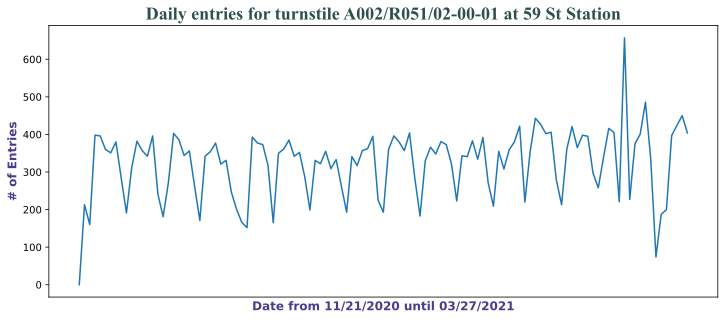

In [39]:
#Let's look at one specific turnstile and graph it
single_turnstile = df_daily[(df_daily["C/A"] == "A002") & 
(df_daily["UNIT"] == "R051") & 
(df_daily["SCP"] == "02-00-01") & 
(df_daily["STATION"] == "59 ST")]

#Dropping potential outliers
drop_outlier(single_turnstile)

#Lets' plot only 1 single turnstile's DAILY_ENTRIES against the DATE on the span of over 3month's worth of data.
plt.figure(figsize=(12,5))
plt.plot(single_turnstile["DATE"], single_turnstile["DAILY_ENTRIES"])
plt.ylabel('# of Entries',fontdict=axis_font_dict)
plt.xlabel('Date from 11/21/2020 until 03/27/2021',fontdict=axis_font_dict)
plt.xticks([])
plt.title("Daily entries for turnstile A002/R051/02-00-01 at 59 St Station",fontdict=title_font_dict)
plt.show();

In [40]:
station_totals.head(10)

,STATION,DAILY_ENTRIES
0,34 ST-PENN STA,4984528.0
1,86 ST,3597779.0
2,23 ST,3451570.0
3,34 ST-HERALD SQ,3274671.0
4,GRD CNTRL-42 ST,3269451.0
5,42 ST-PORT AUTH,3109270.0
6,FULTON ST,2996365.0
7,59 ST,2866934.0
8,14 ST-UNION SQ,2803134.0
9,125 ST,2731569.0


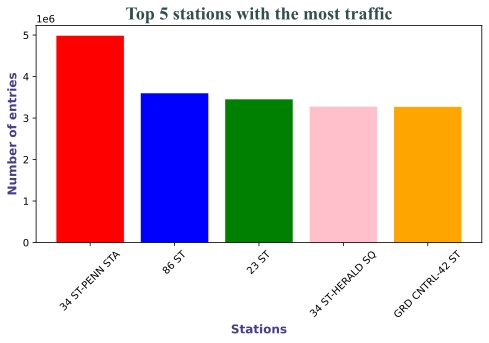

In [66]:
#Plot the bar chart to display the traffic of the top 5 stations
plt.figure(figsize=(8,4))
plt.bar(x=station_totals['STATION'][:5], height=station_totals['DAILY_ENTRIES'][:5], color=['red', 'blue', 'green', 'pink', 'orange'])
plt.ylabel("Number of entries",fontdict=axis_font_dict)
plt.xlabel("Stations",fontdict=axis_font_dict)
plt.xticks(rotation=45)
plt.title("Top 5 stations with the most traffic", fontdict=title_font_dict);
plt.savefig("top_5_barchart.png")

#### Top 5 stations with the most traffic:
1. 34 St - Penn Station (near Korean town - Manhattan)
2. 86 St Station (Upper East Side - Yorkville)
3. 23 St Station (near Korean town - Manhattan)
4. 34 St - Herald Square Station (near Korean town - Manhattan)
5. Grand Central - 42 St Station (near Korean town - Manhattan)

- Let's take a closer look into **34 St - Penn Station**

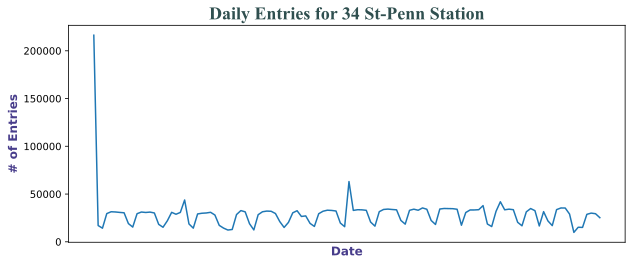

In [42]:
#Filter out df for 34 st station
station_daily_34_st = station_daily[station_daily.STATION == "34 ST-PENN STA"]

#Dropping potential outliers
drop_outlier(station_daily_34_st)

#Plotting the figure
plt.figure(figsize=(10,4))
plt.plot(station_daily_34_st['DATE'], station_daily_34_st['DAILY_ENTRIES'])
plt.ylabel('# of Entries',fontdict=axis_font_dict)
plt.xlabel('Date',fontdict=axis_font_dict)
plt.xticks([])
plt.title('Daily Entries for 34 St-Penn Station', fontdict=title_font_dict)
plt.show()

- The spike in the very beginning is obviously the outlier, so let's drop that row as well.

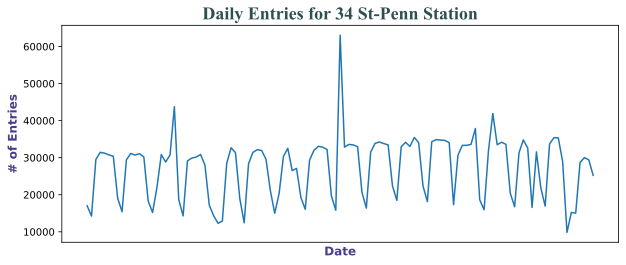

In [43]:
station_daily_34_st.drop(station_daily_34_st[station_daily_34_st.DAILY_ENTRIES > 100000].index, inplace=True)
plt.figure(figsize=(10,4))
plt.plot(station_daily_34_st['DATE'], station_daily_34_st['DAILY_ENTRIES'])
plt.ylabel('# of Entries', fontdict=axis_font_dict)
plt.xlabel('Date', fontdict=axis_font_dict)
plt.xticks([])
plt.title('Daily Entries for 34 St-Penn Station',fontdict=title_font_dict)
plt.show()

In [44]:
station_daily_34_st['DAY_OF_WEEK_NUM'] = pd.to_datetime(station_daily_34_st['DATE']).dt.dayofweek
station_daily_34_st['WEEK_OF_YEAR'] = pd.to_datetime(station_daily_34_st['DATE']).dt.week
station_daily_34_st.head()

,STATION,DATE,DAILY_ENTRIES,DAY_OF_WEEK_NUM,WEEK_OF_YEAR
7245,34 ST-PENN STA,01/02/2021,17021.0,5,53
7246,34 ST-PENN STA,01/03/2021,14253.0,6,53
7247,34 ST-PENN STA,01/04/2021,29522.0,0,1
7248,34 ST-PENN STA,01/05/2021,31448.0,1,1
7249,34 ST-PENN STA,01/06/2021,31217.0,2,1


In [45]:
station_daily_34_st.groupby('DAY_OF_WEEK_NUM').sum().DAILY_ENTRIES

DAY_OF_WEEK_NUM
0    518525.0
1    541178.0
2    546978.0
3    523393.0
4    500044.0
5    310611.0
6    267962.0
Name: DAILY_ENTRIES, dtype: float64

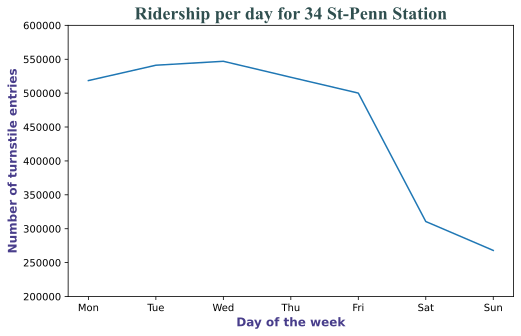

In [46]:
plt.figure(figsize=(8,5))
sns.lineplot(x=np.arange(7), y=station_daily_34_st.groupby('DAY_OF_WEEK_NUM').sum().DAILY_ENTRIES)
    
plt.xlabel('Day of the week',fontdict=axis_font_dict)
plt.ylabel('Number of turnstile entries',fontdict=axis_font_dict)
plt.xticks(np.arange(7),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylim([200000,600000])
plt.title('Ridership per day for 34 St-Penn Station',fontdict=title_font_dict);

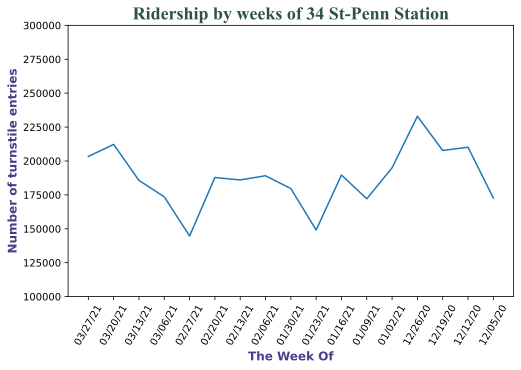

In [47]:
list_of_week = [210327, 210320, 210313, 210306, 210227, 210220, 210213, 210206, 210130, 
             210123, 210116, 210109, 210102, 201226, 201219, 201212, 201205]
for i in range(len(list_of_week)):
    list_of_week[i] = str(list_of_week[i])[2:4] + "/" + str(list_of_week[i])[4:6] + "/" + str(list_of_week[i])[0:2]

station_daily_34_st_df = pd.DataFrame(station_daily_34_st.groupby('WEEK_OF_YEAR').sum().DAILY_ENTRIES.reset_index())
station_daily_34_st_df.drop(axis=0, index=12, inplace=True)
station_daily_34_st_df = station_daily_34_st_df.reset_index().drop(axis=1, columns='index')

for i in range(len(station_daily_34_st_df)):
    if station_daily_34_st_df.WEEK_OF_YEAR[i] < 40:
        station_daily_34_st_df.WEEK_OF_YEAR[i] += 53
station_daily_34_st_df.sort_values('WEEK_OF_YEAR', inplace=True)

plt.figure(figsize=(8,5))
sns.lineplot(x = np.arange(17), y=station_daily_34_st_df.DAILY_ENTRIES)
plt.xticks(np.arange(17),list_of_week, rotation=60)
plt.xlabel('The Week Of',fontdict=axis_font_dict)
plt.ylabel('Number of turnstile entries',fontdict=axis_font_dict)
plt.title("Ridership by weeks of 34 St-Penn Station",fontdict=title_font_dict)
plt.ylim([100000,300000]);

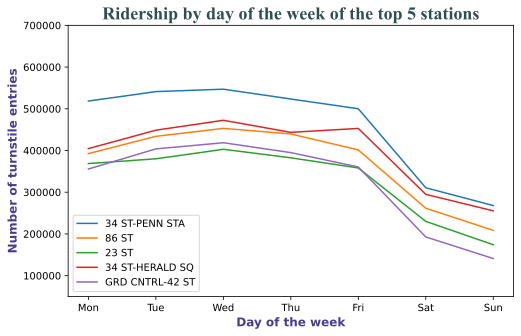

In [48]:
list_of_station = ['34 ST-PENN STA', '86 ST', '23 ST', '34 ST-HERALD SQ', 'GRD CNTRL-42 ST']
plt.figure(figsize=(8,5))
for station in list_of_station:
    station_daily_df = station_daily[station_daily.STATION == station]
    drop_outlier(station_daily_df)
    station_daily_df.drop(station_daily_df[station_daily_df.DAILY_ENTRIES > 100000].index, inplace=True)
    station_daily_df['DAY_OF_WEEK_NUM'] = pd.to_datetime(station_daily_df['DATE']).dt.dayofweek
    station_daily_df['WEEK_OF_YEAR'] = pd.to_datetime(station_daily_df['DATE']).dt.week
    plt.plot(station_daily_df.groupby('DAY_OF_WEEK_NUM').sum().DAILY_ENTRIES)
plt.xlabel('Day of the week',fontdict=axis_font_dict)
plt.ylabel('Number of turnstile entries',fontdict=axis_font_dict)
plt.xticks(np.arange(7),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.title("Ridership by day of the week of the top 5 stations",fontdict=title_font_dict)
plt.ylim([50000,700000])
plt.legend(list_of_station, loc=3);

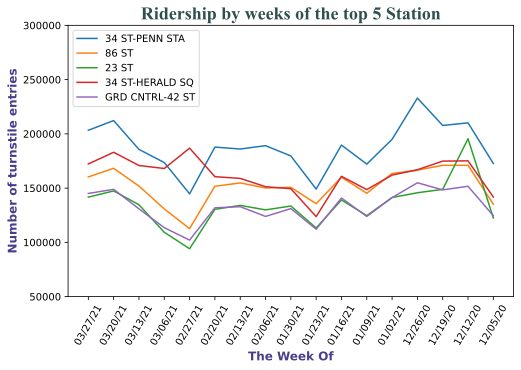

In [49]:
list_of_week = [210327, 210320, 210313, 210306, 210227, 210220, 210213, 210206, 210130, 
             210123, 210116, 210109, 210102, 201226, 201219, 201212, 201205]
for i in range(len(list_of_week)):
    list_of_week[i] = str(list_of_week[i])[2:4] + "/" + str(list_of_week[i])[4:6] + "/" + str(list_of_week[i])[0:2]
    
list_of_station = ['34 ST-PENN STA', '86 ST', '23 ST', '34 ST-HERALD SQ', 'GRD CNTRL-42 ST']

plt.figure(figsize=(8,5))

for station in list_of_station:
    station_daily_df = station_daily[station_daily.STATION == station]
    drop_outlier(station_daily_df)
    station_daily_df.drop(station_daily_df[station_daily_df.DAILY_ENTRIES > 100000].index, inplace=True)
    station_daily_df['DAY_OF_WEEK_NUM'] = pd.to_datetime(station_daily_df['DATE']).dt.dayofweek
    station_daily_df['WEEK_OF_YEAR'] = pd.to_datetime(station_daily_df['DATE']).dt.week
    station_weekly = pd.DataFrame(station_daily_df.groupby('WEEK_OF_YEAR').sum().DAILY_ENTRIES.reset_index())
    station_weekly.drop(axis=0, index=12, inplace=True)
    station_weekly = station_weekly.reset_index().drop(axis=1, columns='index')
    
    for i in range(len(station_weekly)):
        if station_weekly.WEEK_OF_YEAR[i] < 40:
            station_weekly.WEEK_OF_YEAR[i] += 53
    station_weekly.sort_values('WEEK_OF_YEAR', inplace=True)

    sns.lineplot(x = np.arange(17), y=station_weekly.DAILY_ENTRIES)
    

plt.xticks(np.arange(17),list_of_week, rotation=60)
plt.xlabel('The Week Of',fontdict=axis_font_dict)
plt.ylabel('Number of turnstile entries',fontdict=axis_font_dict)
plt.title("Ridership by weeks of the top 5 Stations",fontdict=title_font_dict)
plt.ylim([50000,300000])
plt.legend(list_of_station);

In [ ]:
CLIENT_ID = 'VP20C5A3F11IKFP113UKD034OSLD1352NCLAISJYYE0UKKAE' 
CLIENT_SECRET = '2ANW2CSUTTLD1J04FNQIHSKW2A3RYOBY4O0IYD1DPMM0NDCH' 
ACCESS_TOKEN = 'TLW3H3WI2LGI25ENBZG3QG1ASOC4WCPJJBC5XRJYB5PNRQQB'

VERSION = '20180604'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
print('ACCESS TOKEN :' + ACCESS_TOKEN)

In [ ]:
# Nominatim is used to convert an address into latitude and longitude values

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode('34 St - Penn Station, New York, NY')
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of 34 St - Penn Station, New York, NY are {}, {}.'.format(latitude, longitude))

In [110]:
top_5_stations = ['34 St - Penn Station, New York, NY', '86th St Station, New York, NY', 
                  '23 St Station, New York, NY', '34 St-Herald Sq, New York, NY', 
                  'Grand Central-42 St Station, New York, NY']

corr_dict = {
    '34 St - Penn Station, New York, NY' : {
        'latitude': 40.741895,
        'longitude': -73.989308
    },
    '86th St Station, New York, NY' : {
        'latitude': 40.7794939,
        'longitude': -73.9555295
    },
    '23 St Station, New York, NY' : {
        'latitude': 40.7440859,
        'longitude': -73.995641
    },
    '34 St-Herald Sq, New York, NY' : {
        'latitude': 40.749567,
        'longitude': -73.98795
    },
    'Grand Central-42 St Station, New York, NY' : {
        'latitude': 40.79705,
        'longitude': -73.949604
    },
}

LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

In [121]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#Function to create the word-cloud
def create_the_cloud(station_venues):
    text = station_venues['categories'].head(30).values

    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'white',
        stopwords = STOPWORDS).generate(str(text))
    fig = plt.figure(
        figsize = (6,4),
        facecolor = 'c',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

100 venues were returned by Foursquare around 34 St - Penn Station, New York, NY.
                     name               categories        lat        lng
0     Madison Square Park                     Park  40.742262 -73.988006
1         Eataly Flatiron             Gourmet Shop  40.741987 -73.989913
2             Shake Shack             Burger Joint  40.741484 -73.988218
3                 Dig Inn      American Restaurant  40.740698 -73.988315
4     Eleven Madison Park  New American Restaurant  40.741648 -73.987148
5      Mile High Run Club     Gym / Fitness Center  40.743410 -73.990270
6  Num Pang Sandwich Shop           Sandwich Place  40.743487 -73.989236
7       Rizzoli Bookstore                Bookstore  40.743528 -73.989219
8                  Heyday                      Spa  40.743273 -73.988774
9          The LEGO Store         Toy / Game Store  40.741979 -73.989890
-------------------------------------------------------------------
There are 61 uniques categories around this nei

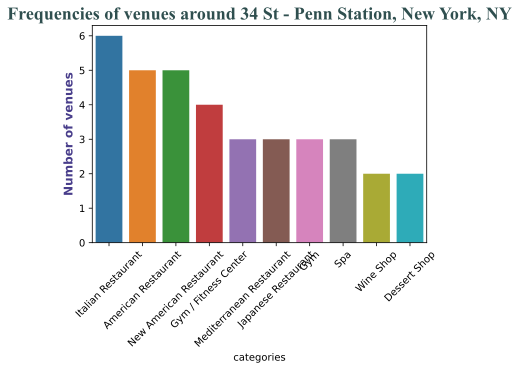

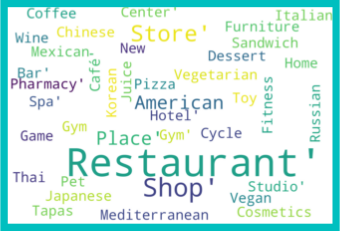

-------------------------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
100 venues were returned by Foursquare around 86th St Station, New York, NY.
                       name            categories        lat        lng
0                   Dig Inn   American Restaurant  40.780332 -73.954728
1  New York Yoga - Hot Yoga           Yoga Studio  40.778910 -73.956160
2   Variety Coffee Roasters           Coffee Shop  40.778899 -73.955900
3         By the Way Bakery                Bakery  40.777948 -73.956669
4               Shake Shack          Burger Joint  40.779099 -73.954686
5             Levain Bakery                Bakery  40.777354 -73.955284
6   Jack’s Stir Brew Coffee           Coffee Shop  40.781152 -73.954383
7                    Rumble  Gym / Fitness Center  40.777826 -73.954773
8  Equinox East 85th Street  Gym / Fitness Center  40.778001 -73.954143

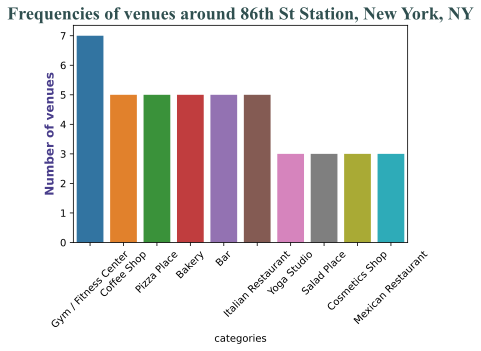

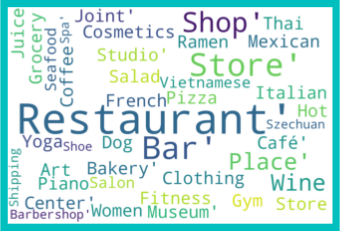

-------------------------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
100 venues were returned by Foursquare around 23 St Station, New York, NY.
                          name           categories        lat        lng
0                      Peloton            Bike Shop  40.743469 -73.994205
1                       Momoya     Sushi Restaurant  40.742687 -73.996617
2      Wellington Hair Spa Inc                  Spa  40.743586 -73.993331
3       Iyengar Yoga Institute          Yoga Studio  40.743121 -73.995291
4  (MALIN+GOETZ) (MALIN+GOETZ)       Cosmetics Shop  40.742560 -73.996795
5                       Rumble           Boxing Gym  40.743640 -73.994447
6     Sebastien Grey Clothiers          Men's Store  40.744197 -73.993825
7         Orangetheory Fitness                  Gym  40.743292 -73.993726
8      Variety Coffee Roasters          Coffee Shop  40

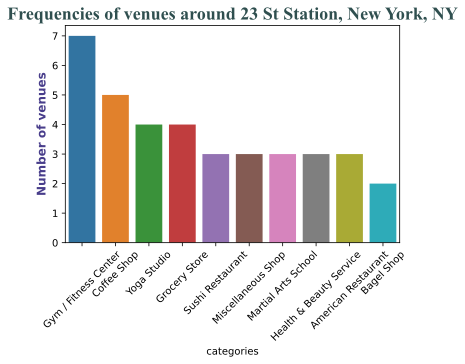

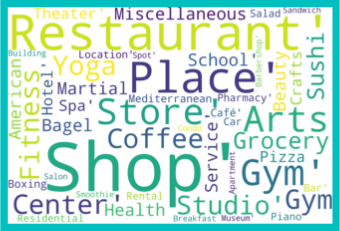

-------------------------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
100 venues were returned by Foursquare around 34 St-Herald Sq, New York, NY.
                          name           categories        lat        lng
0             Keens Steakhouse           Steakhouse  40.750905 -73.986470
1                         Lush       Cosmetics Shop  40.749281 -73.987108
2        Empire State Building             Building  40.748600 -73.985806
3                  Shake Shack         Burger Joint  40.751253 -73.987630
4                  Izakaya MEW  Japanese Restaurant  40.750145 -73.986390
5                Louis Vuitton             Boutique  40.750274 -73.988146
6            Victoria's Secret       Lingerie Store  40.749745 -73.987693
7                   Jongro BBQ    Korean Restaurant  40.747574 -73.987043
8  Anytime Soju Bar and Eatery    Korean Restaurant  

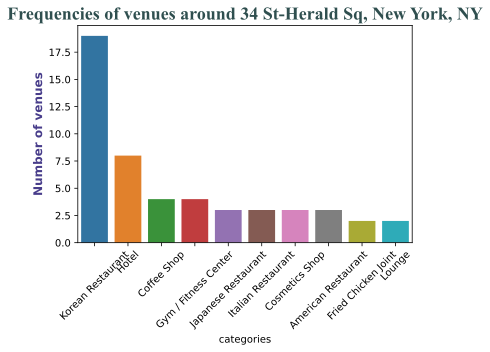

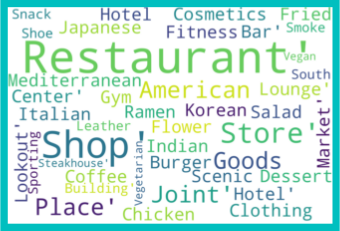

-------------------------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
38 venues were returned by Foursquare around Grand Central-42 St Station, New York, NY.
                                       name          categories        lat  \
0                                   Teranga  African Restaurant  40.796268   
1  Duke Ellington Memorial by Robert Graham   Outdoor Sculpture  40.796901   
2                        Little Bean Coffee         Coffee Shop  40.798929   
3                  Central Park - North End                Park  40.798030   
4                             Farmers' Gate               Plaza  40.798055   
5                              Birch Coffee         Coffee Shop  40.797750   
6                              Fort Clinton      Scenic Lookout  40.795285   
7                         Steak and Hoagies  Chinese Restaurant  40.796465   
8     

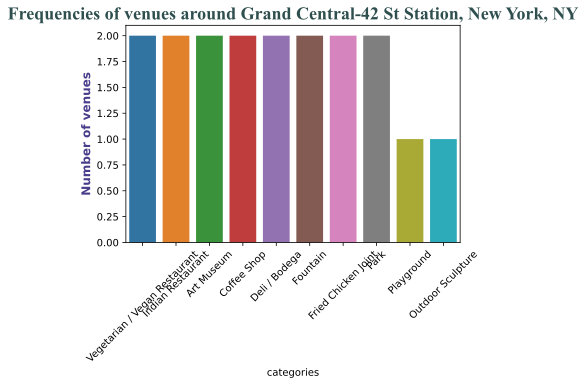

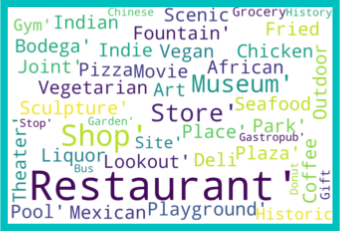

-------------------------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------


In [122]:
for i in range(5):
    
     # create URL using explore 
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        corr_dict[top_5_stations[i]]['latitude'], 
        corr_dict[top_5_stations[i]]['longitude'], 
        radius, 
        LIMIT)
    results = requests.get(url).json()
            
    venues = results['response']['groups'][0]['items']

    nearby_venues = pd.json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues =nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    print('{} venues were returned by Foursquare around {}.'.format(nearby_venues.shape[0],top_5_stations[i]))
    print(pd.DataFrame(nearby_venues.head(10)))
    print('-------------------------------------------------------------------')
    print('There are {} uniques categories around this neighborhood.'.format(len(nearby_venues['categories'].unique())))
    station_venues = nearby_venues.groupby('categories').count().reset_index()
    station_venues = station_venues.sort_values('name', ascending = False)
    station_venues = station_venues[['categories', 'name']]
    station_venues.rename(columns={'name':'frequencies'},inplace = True)
    print(station_venues.head(10))
    print('-------------------------------------------------------------------')
    # Create the plot
    plt.figure(figsize=(6,4))
    sns.barplot(x = "categories", y = "frequencies", data = station_venues.head(10));

    # Add title
    plt.xticks(rotation = 45)
    plt.title('Frequencies of venues around {}'.format(top_5_stations[i]), fontdict=title_font_dict)
    plt.ylabel('Number of venues', fontdict=axis_font_dict)
    print('-------------------------------------------------------------------')
    print('-------------------------------------------------------------------')
    create_the_cloud(station_venues)
    print('-------------------------------------------------------------------')
    print('-------------------------------------------------------------------')
    print('-------------------------------------------------------------------')